In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.listdir('../input/histopathologic-cancer-detection')


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['sample_submission.csv', 'train_labels.csv', 'test', 'train']

# EDA and Setup

## Exploring the data

#### Our goal, from the competition description, is to build a model that detects if any cancerous cells are present in the center 32p x 32p region of a given 96p x 96p image. Let's look at how many training samples we have, and how those are split

In [2]:
import pathlib

train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_sample_len = len(os.listdir(train_path))
test_sample_len = len(os.listdir(test_path))

print("There are " + str(train_sample_len) + " training samples")
print("There are " + str(test_sample_len) + " test samples -- we'll worry about this set later")


There are 220025 training samples
There are 57458 test samples -- we'll worry about this set later


In [3]:
df_raw = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df_raw['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


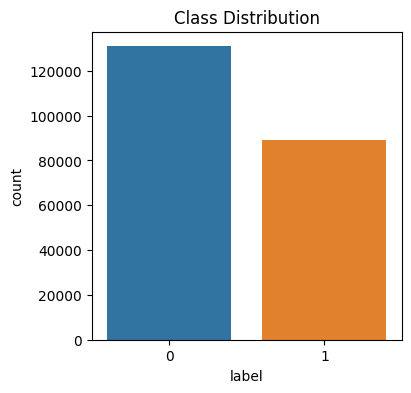

In [5]:
plt.figure(figsize=(4, 4))
sns.countplot(x='label', data=df_raw)
plt.title('Class Distribution')
plt.show()

#### We have 220k training samples and they're split roughly 60/40 into "no cancer present" (class 0) and "cancer present" (class 1). Next, let's get a look at some of the images:

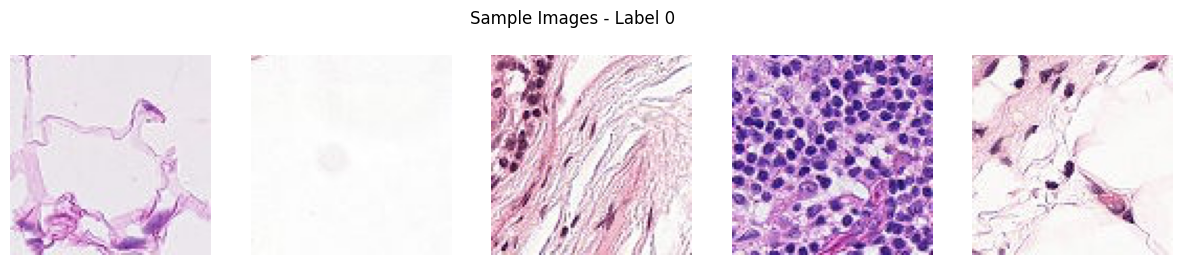

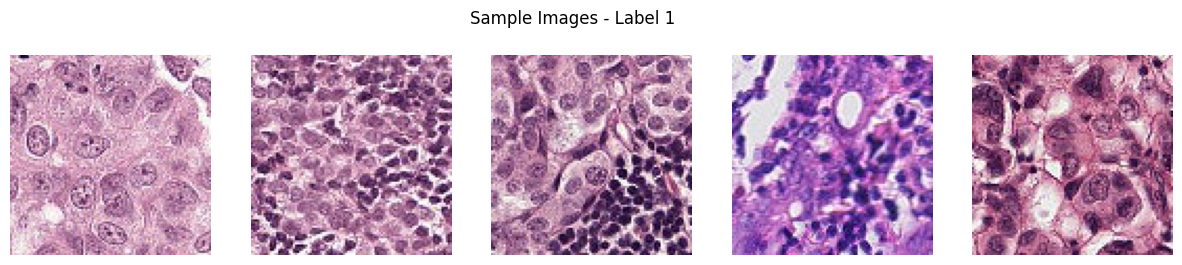

In [6]:
def show_samples(df, label, num_samples=5):
    samples = df[df['label'] == label].sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_name + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample Images - Label {label}')
    plt.show()

show_samples(df_raw, label=0)
show_samples(df_raw, label=1)

#### I'll be the first to admit that I don't know anything about histology so I have no clue what to look for between positive cases (class 1) and negative cases (class 0)

## Cleaning and splitting the data

#### There aren't any nulls in this dataset, so we're going to set up the train/test split (I'll use the term 'validation' to not confuse us with the given 'test' directory) and do some basic data cleaning to make future data processing easier. 

#### The given dataframe only has two columns -- label and id. We'll turn this 'id' column into a full filename so that our data generators know where to look/what to grab when building the inputs to the CNN

### Update: After trying to train a model on the full dataset, I decided to slim down our training set to about 80k images from each class. This speeds up training significantly while maintaining performance on the test set

In [7]:
# first, convert our labels to strings
df_raw['label'] = df_raw['label'].astype(str)

# create a new column that contains the full filename (append '.tif' to the ids)
df_raw['filename'] = df_raw['id'] + '.tif'

df_raw.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [8]:
from sklearn.model_selection import train_test_split
SAMPLE_SIZE = 80000

df_no_cancer = df_raw[df_raw['label']=='0'].sample(SAMPLE_SIZE,random_state=4133)
df_cancer = df_raw[df_raw['label']=='1'].sample(SAMPLE_SIZE,random_state=4133)

# concat the dataframes
df_sample = pd.concat([df_no_cancer, df_cancer], axis=0).reset_index(drop=True)
# shuffle
df_sample = shuffle(df_sample)

df_train, df_val = train_test_split(df_sample, test_size = 0.15, random_state=4133)

print("Training datafram has: " +str(len(df_train))+ " samples")
print("Validation datafram has: " +str(len(df_val))+ " samples")

Training datafram has: 136000 samples
Validation datafram has: 24000 samples


# Building and Tuning

#### First, we'll add our ImageGenerators. These are responsible for actually fetching the image data from our training directory. They also allow us to specify random transformations of the data. These transformations can help boost model performance by reducing overfitting

#### We'll go ahead and add some random horizontal/vertical flips. I don't want to do any other transformations (you can stretch and squash images too) since we want to preserve that inner 32 x 32 section that we're predicting on.

In [9]:
BATCH_SIZE = 32

imggen_train = ImageDataGenerator(
    rescale = 1.0/255,
    horizontal_flip = True,
    vertical_flip = True
)

imggen_val = ImageDataGenerator(
    rescale = 1.0/255
)

generator_train = imggen_train.flow_from_dataframe(
    dataframe = df_train,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96), # input image size
    batch_size = BATCH_SIZE, # we may adjust this batch size when tuning
    class_mode = 'binary'
)

generator_val = imggen_val.flow_from_dataframe(
    dataframe = df_val,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96), # input image size
    batch_size = BATCH_SIZE, # we may adjust this batch size when tuning
    class_mode = 'binary'
)

Found 136000 validated image filenames belonging to 2 classes.
Found 24000 validated image filenames belonging to 2 classes.


## Basic Architechture 

#### We'll start with a simple CNN -- 2 Convolution layers with Max Pooling after each one. These will feed into a dense layer and finally an output. For now, we'll skip any sort of batch normalization or dropout. This will give us a baseline to compare against

In [10]:
model_base = Sequential([
    InputLayer((96,96,3)),
    # Layer one
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Layer two
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Output
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate = learning_rate)

model_base.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model_base.build()
model_base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,982,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,992,865 (7.60 MB)

 Trainable params: 1,992,865 (7.60 MB)

 Non-trainable params: 0 (0.00 B)

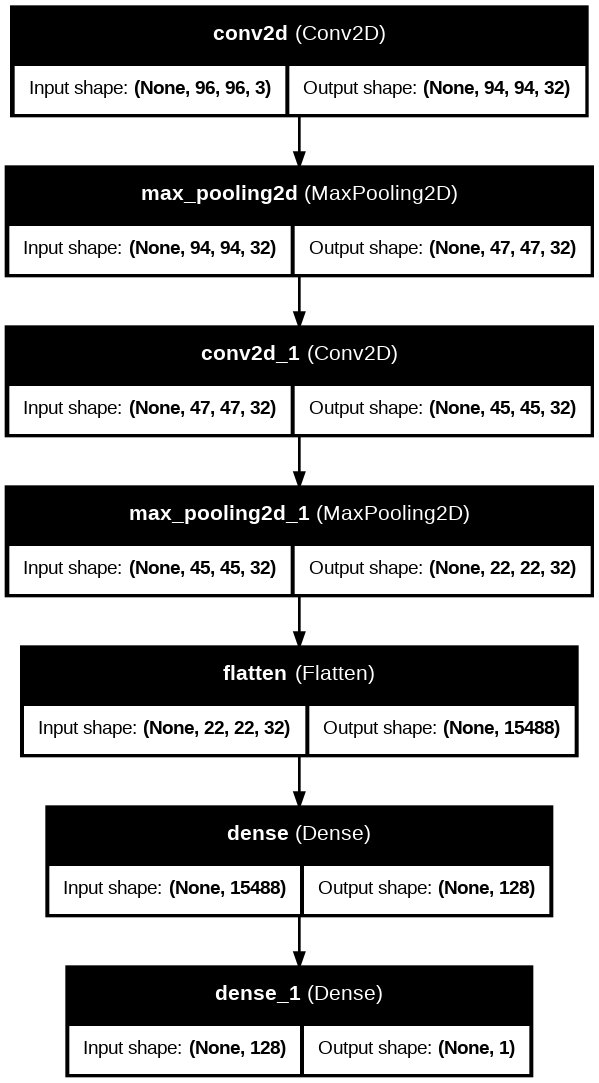

In [11]:
# We can also get this pretty picture of our layers:
tf.keras.utils.plot_model(
    model_base,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Train and plot some validation

In [12]:
# Turn off base model training for submission
base_history = model_base.fit(generator_train, epochs = 10, validation_data = generator_val)

base_metrics = pd.DataFrame(base_history.history)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4250/4250 ━━━━━━━━━━━━━━━━━━━━ 1149s 269ms/step - accuracy: 0.7682 - loss: 0.4946 - val_accuracy: 0.8225 - val_loss: 0.4077
Epoch 2/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 315s 74ms/step - accuracy: 0.8303 - loss: 0.3877 - val_accuracy: 0.8515 - val_loss: 0.3422
Epoch 3/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 208s 49ms/step - accuracy: 0.8493 - loss: 0.3479 - val_accuracy: 0.8613 - val_loss: 0.3244
Epoch 4/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 257s 48ms/step - accuracy: 0.8592 - loss: 0.3267 - val_accuracy: 0.8718 - val_loss: 0.3033
Epoch 5/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 212s 50ms/step - accuracy: 0.8668 - loss: 0.3156 - val_accuracy: 0.8789 - val_loss: 0.2945
Epoch 6/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 215s 51ms/step - accuracy: 0.8736 - loss: 0.3000 - val_accuracy: 0.8695 - val_loss: 0.3190
Epoch 7/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 207s 49ms/step - accuracy: 0.8785 - loss: 0.2870 - val_accuracy: 0.8739 - val_loss: 0.2981
Epoch 8/10
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 204s 48ms/step - accuracy: 0.8852 - 

#### In total, this base model took 53 minutes to train, and we ended with a validation accuracy of 88.76%.

## Callbacks and Fine-tuning

#### Next, we'll add some batch normalization, dropout, and patience to try and get a better model

#### In addition, we'll add another convolution layer to the network. These images are complex, and another layer of convolution could help better identify high-level patterns that differentiate cancerous and non-cancerous images

In [20]:
model_tuned = Sequential([
    InputLayer((96,96,3)),
    # Layer one
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Layer two
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Layer three
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    
    # Output
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
opt = keras.optimizers.Adam(learning_rate = learning_rate)

model_tuned.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model_tuned.build()
model_tuned.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 22, 22, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 20, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 10, 10, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 430,145 (1.64 MB)

 Trainable params: 429,697 (1.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
callbacks = [EarlyStopping(patience=3)]
generator_train.reset()
generator_val.reset()

tuned_history = model_tuned.fit(generator_train, epochs = 25, validation_data = generator_val, callbacks=callbacks)

Epoch 1/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 346s 80ms/step - accuracy: 0.7590 - loss: 0.5612 - val_accuracy: 0.8394 - val_loss: 0.3671
Epoch 2/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 201s 47ms/step - accuracy: 0.8232 - loss: 0.4028 - val_accuracy: 0.8298 - val_loss: 0.3803
Epoch 3/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 205s 48ms/step - accuracy: 0.8429 - loss: 0.3624 - val_accuracy: 0.8691 - val_loss: 0.3126
Epoch 4/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 202s 47ms/step - accuracy: 0.8561 - loss: 0.3383 - val_accuracy: 0.8790 - val_loss: 0.2886
Epoch 5/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 194s 45ms/step - accuracy: 0.8672 - loss: 0.3165 - val_accuracy: 0.8865 - val_loss: 0.2752
Epoch 6/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 205s 48ms/step - accuracy: 0.8735 - loss: 0.3034 - val_accuracy: 0.8660 - val_loss: 0.3153
Epoch 7/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 205s 48ms/step - accuracy: 0.8794 - loss: 0.2916 - val_accuracy: 0.8920 - val_loss: 0.2641
Epoch 8/25
4250/4250 ━━━━━━━━━━━━━━━━━━━━ 193s 45ms/step - accuracy: 

In [22]:
tuned_metrics = pd.DataFrame(tuned_history.history)

# Validation

## Exploring the results

<Axes: >

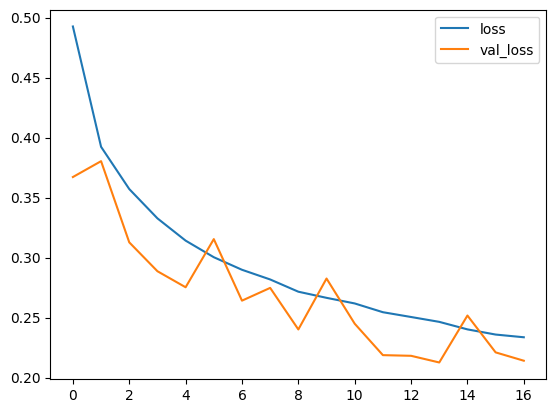

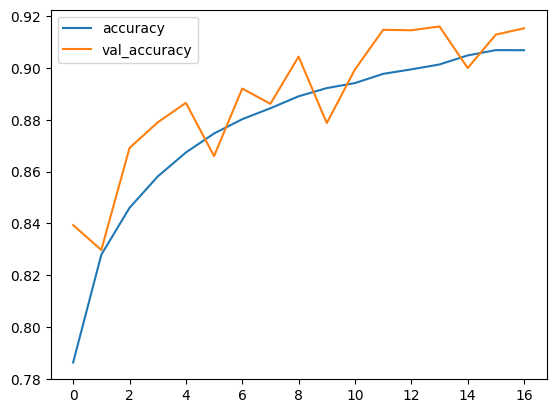

In [27]:
base_metrics[["loss","val_loss"]].plot()
base_metrics[['accuracy', 'val_accuracy']].plot()

<Axes: >

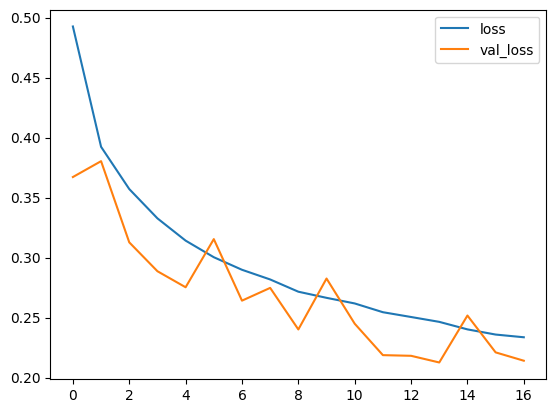

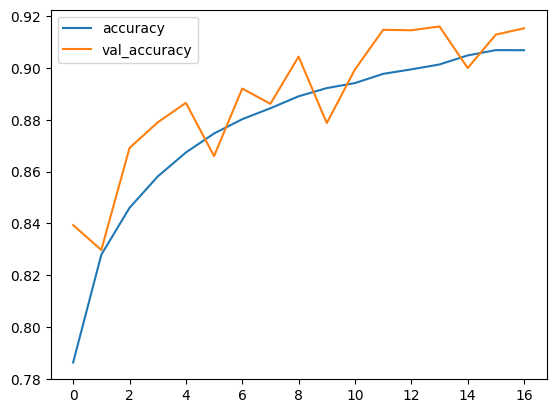

In [24]:
tuned_metrics[["loss","val_loss"]].plot()
tuned_metrics[['accuracy', 'val_accuracy']].plot()

## Comparisons

#### The addition of an extra convolution layer, some batch normalization, and the dropout layer before our final dense network showed some great improvement in our training and validation accuracy. When we compare the graphs of the two models, we can see that the validation accuracy and loss are not as smooth as the training metrics. This may be caused by a couple of different factors. My intial guess is that the learning rate is a bit high and we may be over-fitting the data. In future iterations, I would add a learning rate scheduler, as well as tinker with different architectures for the batch normalization (putting it before the pooling) and maybe add dropout layers during the convolution steps as well.

#### Another approach could be to take a pre-trained model like imagenet and try to build on top of that. Maybe unfreezing the dense layer and retraining our own could lead to a more robust adaption over the problem space

# Conclusions

In [34]:
df_test = pd.DataFrame({'id': os.listdir(test_dir)})

generator_test = imggen_val.flow_from_dataframe(
    dataframe = df_test,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96, 96),
    batch_size=1, # batch only one at a time, predict method needs batch size to evenly divide steps
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [35]:
generator_test.reset()

predictions = model_tuned.predict(generator_test, steps=generator_test.samples)


# Prepare the submission DataFrame
filenames = generator_test.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})


# Save submission.csv
submission_df.to_csv('submission.csv', index=False)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 123s 2ms/step


#### We ended with a final score on the test dataset of 0.808. It's not the greatest score, and future experimentation is warranted to come to a better architecture. 